In [1]:
import epics
import numpy as _np

from mathphys.imgproc import Image2D_Fit as _Image2D_Fit
from siriuspy.devices import Device as _Device, DVF as _DVF

In [31]:
class DVFImgProc(_DVF):
    """."""
    
    _properties = _DVF._properties + (
        'ImgROIX-SP', 'ImgROIX-RB',
        'ImgROIY-SP', 'ImgROIY-RB',
        'ImgROIXCenter-Mon', 'ImgROIYCenter-Mon',
        'ImgROIXFWHM-Mon', 'ImgROIYFWHM-Mon',
        'ImgROIXUpdateWithFWHMFactor-SP', 'ImgROIXUpdateWithFWHMFactor-RB',
        'ImgROIYUpdateWithFWHMFactor-SP', 'ImgROIYUpdateWithFWHMFactor-RB',
        'ImgROIUpdateWithFWHM-Sel', 'ImgROIUpdateWithFWHM-Sts',
    )
    
    def __init__(self, devname, *args, **kwargs):
        """."""
        super().__init__(devname=devname, *args, **kwargs)
        self.wait_for_connection(timeout=5)
        self.cmd_update()
        
    @property
    def roiy(self):
        """."""
        return self['ImgROIY-RB']
    
    @roiy.setter
    def roiy(self, value):
        """."""
        self['ImgROIY-SP'] = value
    
    @property
    def roix(self):
        """."""
        return self['ImgROIX-RB']
    
    @roix.setter
    def roix(self, value):
        """."""
        self['ImgROIX-SP'] = value

    @property
    def roiy_center(self):
        """."""
        return self['ImgROIYCenter-Mon']
    
    @property
    def roix_center(self):
        """."""
        return self['ImgROIXCenter-Mon']
    
    @property
    def roiy_fwhm(self):
        """."""
        return self['ImgROIYFWHM-Mon']
    
    @property
    def roix_fwhm(self):
        """."""
        return self['ImgROIXFWHM-Mon']
    
    @property
    def fwhmy_factor(self):
        """."""
        return self['ImgROIYUpdateWithFWHMFactor-RB']
    
    @fwhmy_factor.setter
    def fwhmy_factor(self, value):
        """."""
        self['ImgROIYUpdateWithFWHMFactor-SP'] = value
        
    @property
    def fwhmx_factor(self):
        """."""
        return self['ImgROIXUpdateWithFWHMFactor-RB']
    
    @fwhmx_factor.setter
    def fwhmx_factor(self, value):
        """."""
        self['ImgROIXUpdateWithFWHMFactor-SP'] = value
    
    @property
    def roi_with_fwhm(self):
        """."""
        return self['ImgROIUpdateWithFWHM-Sts']
    
    @roi_with_fwhm.setter
    def roi_with_fwhm(self, value):
        """."""
        self['ImgROIUpdateWithFWHM-Sel'] = value == True
        
    @property
    def image2dfit(self):
        """."""
        return self._image2dfit
    
    def cmd_update(self):
        """."""
        self._image2dfit = _Image2D_Fit(data=self.image, roix=self.roix, roiy=self.roiy)
        
        
def update_image(dvfimgproc):
    dvfimgproc.cmd_acquire_on()
    dvfimgproc.cmd_update()
    img = dvfimgproc.image2dfit
    return img

In [4]:
dvfimgproc = DVFImgProc(devname=DVFImgProc.DEVICES.CAX_DVF2)

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 142
intensity_avg   : 1.3747756958007813
intensity_sum   : 1801946
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 887
intensity_max   : 6836
intensity_avg   : 1407.7703125
intensity_sum   : 1801946
saturation_val  : 255
saturated       : False
roi             : [380 578]
roi_center      : 479
roi_fwhm        : 99
roi_amplitude   : 5331.594412856457
roi_mean        : 477.2713237212349
roi_sigma       : 39.150135152046985
roi_fit_err     : 8.364089899387462 %
roi_amplitude   : 5331.594412856457
roi_mean        : 477.2713237212349
roi_sigma       : 39.150135152046985
roi_fit_err     : 8.364089899387462 %
--- fity ---
size            : 1024
intensity_min   : 1093
intensity_max   : 13571
intensity_avg   : 1759.712890625
intensity_sum   : 1801946
saturation_val  : 255
saturated       : False
roi             : [229 317]
roi_center      : 273
roi_fwhm        

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbead592198>)

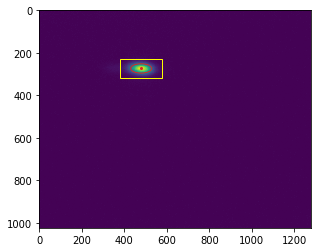

In [44]:
img = update_image(dvfimgproc)
print(img)
img.imshow()

In [43]:
print(dvfimgproc.roix, dvfimgproc.roiy)

[376 576] [229 317]


In [8]:
dvfimgproc.roix = [400, 800]
dvfimgproc.roiy = [0, 200]

In [39]:
print(dvfimgproc.roix_center, dvfimgproc.roiy_center)

483 274


In [40]:
print(dvfimgproc.roix_fwhm, dvfimgproc.roiy_fwhm)

100 43


In [41]:
print(dvfimgproc.fwhmx_factor, dvfimgproc.fwhmy_factor)

1.5 1.5


In [13]:
dvfimgproc.fwhmx_factor = 1.5
dvfimgproc.fwhmy_factor = 1.5

In [19]:
dvfimgproc.roi_with_fwhm

1

In [42]:
dvfimgproc.roi_with_fwhm = True

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 143
intensity_avg   : 1.3658889770507812
intensity_sum   : 1790298
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 882
intensity_max   : 6840
intensity_avg   : 1398.6703125
intensity_sum   : 1790298
saturation_val  : 255
saturated       : False
roi             : [379 579]
roi_center      : 479
roi_fwhm        : 100
roi_amplitude   : 5318.000312134282
roi_mean        : 476.0722285005657
roi_sigma       : 39.224434522016765
roi_fit_err     : 8.270113180263827 %
roi_amplitude   : 5318.000312134282
roi_mean        : 476.0722285005657
roi_sigma       : 39.224434522016765
roi_fit_err     : 8.270113180263827 %
--- fity ---
size            : 1024
intensity_min   : 1025
intensity_max   : 13634
intensity_avg   : 1748.337890625
intensity_sum   : 1790298
saturation_val  : 255
saturated       : False
roi             : [220 306]
roi_center      : 270
roi_fwhm       

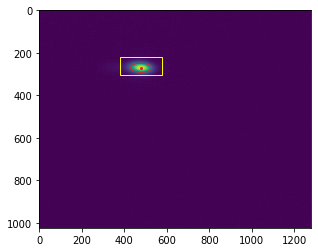

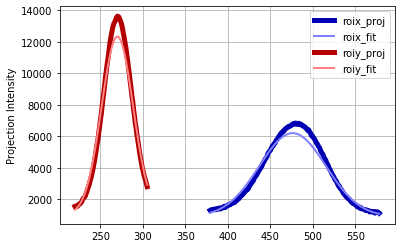

In [45]:
dvfimgproc.cmd_update()
img = dvfimgproc.image2dfit
print(img)
img.imshow()
img.plot_projections()

In [56]:
print(img)

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 182
intensity_avg   : 1.6747734069824218
intensity_sum   : 2195159
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 928
intensity_max   : 10588
intensity_avg   : 1714.96796875
intensity_sum   : 2195159
saturation_val  : 255
saturated       : False
roi             : [368 558]
roi_center      : 460
roi_fwhm        : 96
roi_amplitude   : 9033.741208981864
roi_mean        : 456.1244833602748
roi_sigma       : 38.26839927655697
roi_fit_err     : 5.161581101930484 %
roi_amplitude   : 9033.741208981864
roi_mean        : 456.1244833602748
roi_sigma       : 38.26839927655697
roi_fit_err     : 5.161581101930484 %
--- fity ---
size            : 1024
intensity_min   : 1061
intensity_max   : 17599
intensity_avg   : 2143.7099609375
intensity_sum   : 2195159
saturation_val  : 255
saturated       : False
roi             : [232 326]
roi_center      : 280
roi_fwhm       